# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1_wisig-metehan",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 19,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": 100,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
                15,
                16,
                17,
                18,
            ],
            "domains": [0, 1, 2],
            "num_examples_per_domain_per_label": 100,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/metehan.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "Metehan_",
        },
    ],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'Wisig_2', 'Wisig_1', 'Wisig_4', 'Wisig_3'}


{'Metehan_1', 'Metehan_0', 'Metehan_2'}


tensor([[[ 0.0657,  0.0591, -0.1341,  ..., -0.1918,  0.0493,  0.3547],
         [ 0.0452, -0.0085, -0.4762,  ...,  0.6399,  0.1289, -0.2542]],

        [[ 1.2026, -0.2104, -1.3825,  ...,  0.7540, -0.3066, -1.2589],
         [ 0.3994,  1.1195, -0.0503,  ...,  0.6375,  0.9621, -0.3637]],

        [[ 0.0390, -0.1923, -0.2423,  ...,  0.1582,  0.0344,  0.4824],
         [-0.0818,  0.0413, -0.8267,  ...,  0.1785, -0.2993, -0.7380]],

        ...,

        [[-0.2163,  0.4422,  0.0191,  ..., -0.3633,  0.0179, -0.2390],
         [-0.0335, -0.0096,  0.7780,  ...,  0.6023,  0.9082,  1.2022]],

        [[ 0.1546, -0.1775, -0.8332,  ..., -0.5554, -0.8863, -1.1749],
         [-0.2077,  0.5120, -0.2536,  ..., -0.3864, -0.2101, -0.3961]],

        [[-0.2882, -1.1865, -1.4342,  ...,  0.1790, -0.6383, -0.5797],
         [ 1.1190,  0.8116,  0.0236,  ...,  1.0267,  1.2766,  0.6631]]])


In [21]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 1128], examples_per_second: 238.9891, train_label_loss: 2.9103, 


epoch: 1, [batch: 113 / 1128], examples_per_second: 3217.2848, train_label_loss: 0.4123, 


epoch: 1, [batch: 226 / 1128], examples_per_second: 3227.9962, train_label_loss: 0.6998, 


epoch: 1, [batch: 339 / 1128], examples_per_second: 3214.1660, train_label_loss: 0.5836, 


epoch: 1, [batch: 451 / 1128], examples_per_second: 3234.5109, train_label_loss: 0.1380, 


epoch: 1, [batch: 564 / 1128], examples_per_second: 3205.5883, train_label_loss: 0.2945, 


epoch: 1, [batch: 677 / 1128], examples_per_second: 3220.7357, train_label_loss: 0.0706, 


epoch: 1, [batch: 789 / 1128], examples_per_second: 3203.8284, train_label_loss: 0.1217, 


epoch: 1, [batch: 902 / 1128], examples_per_second: 3239.8457, train_label_loss: 0.4920, 


epoch: 1, [batch: 1015 / 1128], examples_per_second: 3217.8581, train_label_loss: 0.1947, 


epoch: 1, source_val_acc_label: 0.9314, target_val_acc_label: 0.2602, source_val_label_loss: 0.3035, target_val_label_loss: 2.7833, 


New best


epoch: 2, [batch: 1 / 1128], examples_per_second: 32.6662, train_label_loss: 0.0662, 


epoch: 2, [batch: 113 / 1128], examples_per_second: 3233.1740, train_label_loss: 0.2674, 


epoch: 2, [batch: 226 / 1128], examples_per_second: 3241.1919, train_label_loss: 0.4552, 


epoch: 2, [batch: 339 / 1128], examples_per_second: 3250.7935, train_label_loss: 0.0706, 


epoch: 2, [batch: 451 / 1128], examples_per_second: 3243.4199, train_label_loss: 0.1119, 


epoch: 2, [batch: 564 / 1128], examples_per_second: 3250.2019, train_label_loss: 0.0513, 


epoch: 2, [batch: 677 / 1128], examples_per_second: 3253.9728, train_label_loss: 0.1072, 


epoch: 2, [batch: 789 / 1128], examples_per_second: 3241.8761, train_label_loss: 0.1552, 


epoch: 2, [batch: 902 / 1128], examples_per_second: 3248.6268, train_label_loss: 0.0426, 


epoch: 2, [batch: 1015 / 1128], examples_per_second: 3261.4864, train_label_loss: 0.0296, 


epoch: 2, source_val_acc_label: 0.9470, target_val_acc_label: 0.2734, source_val_label_loss: 0.2361, target_val_label_loss: 2.7356, 


New best


epoch: 3, [batch: 1 / 1131], examples_per_second: 32.8736, train_label_loss: 0.2015, 


epoch: 3, [batch: 114 / 1131], examples_per_second: 3285.8151, train_label_loss: 0.0838, 


epoch: 3, [batch: 227 / 1131], examples_per_second: 3280.5947, train_label_loss: 0.0520, 


epoch: 3, [batch: 340 / 1131], examples_per_second: 3282.3740, train_label_loss: 0.2125, 


epoch: 3, [batch: 453 / 1131], examples_per_second: 3221.6458, train_label_loss: 0.0885, 


epoch: 3, [batch: 566 / 1131], examples_per_second: 3211.2948, train_label_loss: 0.0135, 


epoch: 3, [batch: 679 / 1131], examples_per_second: 3263.8548, train_label_loss: 0.4853, 


epoch: 3, [batch: 792 / 1131], examples_per_second: 3270.9552, train_label_loss: 0.2038, 


epoch: 3, [batch: 905 / 1131], examples_per_second: 3278.3747, train_label_loss: 0.2128, 


epoch: 3, [batch: 1018 / 1131], examples_per_second: 3262.0457, train_label_loss: 0.0040, 


epoch: 3, source_val_acc_label: 0.9539, target_val_acc_label: 0.2281, source_val_label_loss: 0.2098, target_val_label_loss: 2.7652, 


epoch: 4, [batch: 1 / 1128], examples_per_second: 33.1076, train_label_loss: 0.0078, 


epoch: 4, [batch: 113 / 1128], examples_per_second: 3242.5760, train_label_loss: 0.1577, 


epoch: 4, [batch: 226 / 1128], examples_per_second: 3252.4922, train_label_loss: 0.0331, 


epoch: 4, [batch: 339 / 1128], examples_per_second: 3267.0671, train_label_loss: 0.3236, 


epoch: 4, [batch: 451 / 1128], examples_per_second: 3258.6260, train_label_loss: 0.3698, 


epoch: 4, [batch: 564 / 1128], examples_per_second: 3256.6528, train_label_loss: 0.1836, 


epoch: 4, [batch: 677 / 1128], examples_per_second: 3232.8917, train_label_loss: 0.3091, 


epoch: 4, [batch: 789 / 1128], examples_per_second: 3215.6286, train_label_loss: 0.0122, 


epoch: 4, [batch: 902 / 1128], examples_per_second: 3216.5538, train_label_loss: 0.0824, 


epoch: 4, [batch: 1015 / 1128], examples_per_second: 3227.9733, train_label_loss: 0.0689, 


epoch: 4, source_val_acc_label: 0.9533, target_val_acc_label: 0.3289, source_val_label_loss: 0.2285, target_val_label_loss: 2.5518, 


New best


epoch: 5, [batch: 1 / 1128], examples_per_second: 32.7445, train_label_loss: 0.0376, 


epoch: 5, [batch: 113 / 1128], examples_per_second: 3239.3385, train_label_loss: 0.1946, 


epoch: 5, [batch: 226 / 1128], examples_per_second: 3242.8631, train_label_loss: 0.0123, 


epoch: 5, [batch: 339 / 1128], examples_per_second: 3250.7916, train_label_loss: 0.0246, 


epoch: 5, [batch: 451 / 1128], examples_per_second: 3234.6708, train_label_loss: 0.1218, 


epoch: 5, [batch: 564 / 1128], examples_per_second: 3249.3958, train_label_loss: 0.0153, 


epoch: 5, [batch: 677 / 1128], examples_per_second: 3249.8128, train_label_loss: 0.2149, 


epoch: 5, [batch: 789 / 1128], examples_per_second: 3248.3871, train_label_loss: 0.0719, 


epoch: 5, [batch: 902 / 1128], examples_per_second: 3253.2804, train_label_loss: 0.0792, 


epoch: 5, [batch: 1015 / 1128], examples_per_second: 3266.8619, train_label_loss: 0.4487, 


epoch: 5, source_val_acc_label: 0.9505, target_val_acc_label: 0.3567, source_val_label_loss: 0.2342, target_val_label_loss: 2.4136, 


New best


epoch: 6, [batch: 1 / 1128], examples_per_second: 32.7383, train_label_loss: 0.2444, 


epoch: 6, [batch: 113 / 1128], examples_per_second: 3282.2413, train_label_loss: 0.2403, 


epoch: 6, [batch: 226 / 1128], examples_per_second: 3273.2668, train_label_loss: 0.2743, 


epoch: 6, [batch: 339 / 1128], examples_per_second: 3233.6045, train_label_loss: 0.0809, 


epoch: 6, [batch: 451 / 1128], examples_per_second: 3221.9889, train_label_loss: 0.0118, 


epoch: 6, [batch: 564 / 1128], examples_per_second: 3224.4494, train_label_loss: 0.0084, 


epoch: 6, [batch: 677 / 1128], examples_per_second: 3221.1708, train_label_loss: 0.1138, 


epoch: 6, [batch: 789 / 1128], examples_per_second: 3232.9138, train_label_loss: 0.1752, 


epoch: 6, [batch: 902 / 1128], examples_per_second: 3240.9518, train_label_loss: 0.0624, 


epoch: 6, [batch: 1015 / 1128], examples_per_second: 3256.8158, train_label_loss: 0.2266, 


epoch: 6, source_val_acc_label: 0.9492, target_val_acc_label: 0.3874, source_val_label_loss: 0.2422, target_val_label_loss: 2.4142, 


epoch: 7, [batch: 1 / 1129], examples_per_second: 33.1087, train_label_loss: 0.0041, 


epoch: 7, [batch: 113 / 1129], examples_per_second: 3216.6436, train_label_loss: 0.0019, 


epoch: 7, [batch: 226 / 1129], examples_per_second: 3233.2713, train_label_loss: 0.0098, 


epoch: 7, [batch: 339 / 1129], examples_per_second: 3227.5788, train_label_loss: 0.0861, 


epoch: 7, [batch: 452 / 1129], examples_per_second: 3215.9546, train_label_loss: 0.1302, 


epoch: 7, [batch: 565 / 1129], examples_per_second: 3247.0140, train_label_loss: 0.1058, 


epoch: 7, [batch: 677 / 1129], examples_per_second: 3249.6923, train_label_loss: 0.0051, 


epoch: 7, [batch: 790 / 1129], examples_per_second: 3234.0181, train_label_loss: 0.0302, 


epoch: 7, [batch: 903 / 1129], examples_per_second: 3251.5487, train_label_loss: 0.1899, 


epoch: 7, [batch: 1016 / 1129], examples_per_second: 3248.2502, train_label_loss: 0.0797, 


epoch: 7, source_val_acc_label: 0.9548, target_val_acc_label: 0.4035, source_val_label_loss: 0.2281, target_val_label_loss: 2.3232, 


New best


epoch: 8, [batch: 1 / 1127], examples_per_second: 32.7493, train_label_loss: 0.0371, 


epoch: 8, [batch: 113 / 1127], examples_per_second: 3225.2873, train_label_loss: 0.0063, 


epoch: 8, [batch: 226 / 1127], examples_per_second: 3225.7537, train_label_loss: 0.0449, 


epoch: 8, [batch: 338 / 1127], examples_per_second: 3230.3275, train_label_loss: 0.0529, 


epoch: 8, [batch: 451 / 1127], examples_per_second: 3232.2101, train_label_loss: 0.0329, 


epoch: 8, [batch: 564 / 1127], examples_per_second: 3243.2905, train_label_loss: 0.0144, 


epoch: 8, [batch: 676 / 1127], examples_per_second: 3249.6971, train_label_loss: 0.0008, 


epoch: 8, [batch: 789 / 1127], examples_per_second: 3251.2804, train_label_loss: 0.0214, 


epoch: 8, [batch: 901 / 1127], examples_per_second: 3260.0307, train_label_loss: 0.0011, 


epoch: 8, [batch: 1014 / 1127], examples_per_second: 3243.2929, train_label_loss: 0.1004, 


epoch: 8, source_val_acc_label: 0.9571, target_val_acc_label: 0.3392, source_val_label_loss: 0.2347, target_val_label_loss: 2.3195, 


New best


epoch: 9, [batch: 1 / 1127], examples_per_second: 32.7385, train_label_loss: 0.0008, 


epoch: 9, [batch: 113 / 1127], examples_per_second: 3234.9137, train_label_loss: 0.0014, 


epoch: 9, [batch: 226 / 1127], examples_per_second: 3228.2920, train_label_loss: 0.0126, 


epoch: 9, [batch: 338 / 1127], examples_per_second: 3231.2425, train_label_loss: 0.0016, 


epoch: 9, [batch: 451 / 1127], examples_per_second: 3205.5479, train_label_loss: 0.1699, 


epoch: 9, [batch: 564 / 1127], examples_per_second: 3279.9891, train_label_loss: 0.0038, 


epoch: 9, [batch: 676 / 1127], examples_per_second: 3276.5318, train_label_loss: 0.1049, 


epoch: 9, [batch: 789 / 1127], examples_per_second: 3284.6092, train_label_loss: 0.2620, 


epoch: 9, [batch: 901 / 1127], examples_per_second: 3255.0964, train_label_loss: 0.0965, 


epoch: 9, [batch: 1014 / 1127], examples_per_second: 3235.1628, train_label_loss: 0.0245, 


epoch: 9, source_val_acc_label: 0.9605, target_val_acc_label: 0.2515, source_val_label_loss: 0.2188, target_val_label_loss: 2.4452, 


epoch: 10, [batch: 1 / 1129], examples_per_second: 33.0880, train_label_loss: 0.0013, 


epoch: 10, [batch: 113 / 1129], examples_per_second: 3261.5815, train_label_loss: 0.0034, 


epoch: 10, [batch: 226 / 1129], examples_per_second: 3264.9199, train_label_loss: 0.0611, 


epoch: 10, [batch: 339 / 1129], examples_per_second: 3278.9976, train_label_loss: 0.0068, 


epoch: 10, [batch: 452 / 1129], examples_per_second: 3241.4570, train_label_loss: 0.0042, 


epoch: 10, [batch: 565 / 1129], examples_per_second: 3288.2073, train_label_loss: 0.1256, 


epoch: 10, [batch: 677 / 1129], examples_per_second: 3254.7550, train_label_loss: 0.5528, 


epoch: 10, [batch: 790 / 1129], examples_per_second: 3246.0915, train_label_loss: 0.0175, 


epoch: 10, [batch: 903 / 1129], examples_per_second: 3249.4237, train_label_loss: 0.2995, 


epoch: 10, [batch: 1016 / 1129], examples_per_second: 3247.9746, train_label_loss: 0.0713, 


epoch: 10, source_val_acc_label: 0.9610, target_val_acc_label: 0.2968, source_val_label_loss: 0.2415, target_val_label_loss: 2.2970, 


New best


epoch: 11, [batch: 1 / 1130], examples_per_second: 32.7305, train_label_loss: 0.0006, 


epoch: 11, [batch: 113 / 1130], examples_per_second: 3264.7050, train_label_loss: 0.0327, 


epoch: 11, [batch: 226 / 1130], examples_per_second: 3278.5473, train_label_loss: 0.0506, 


epoch: 11, [batch: 339 / 1130], examples_per_second: 3282.9864, train_label_loss: 0.3372, 


epoch: 11, [batch: 452 / 1130], examples_per_second: 3232.2683, train_label_loss: 0.0049, 


epoch: 11, [batch: 565 / 1130], examples_per_second: 3285.0890, train_label_loss: 0.0361, 


epoch: 11, [batch: 678 / 1130], examples_per_second: 3276.9560, train_label_loss: 0.3054, 


epoch: 11, [batch: 791 / 1130], examples_per_second: 3262.1121, train_label_loss: 0.1963, 


epoch: 11, [batch: 904 / 1130], examples_per_second: 3280.5595, train_label_loss: 0.0110, 


epoch: 11, [batch: 1017 / 1130], examples_per_second: 3260.6734, train_label_loss: 0.0481, 


epoch: 11, source_val_acc_label: 0.9622, target_val_acc_label: 0.3173, source_val_label_loss: 0.2520, target_val_label_loss: 2.3214, 


epoch: 12, [batch: 1 / 1131], examples_per_second: 33.0294, train_label_loss: 0.0034, 


epoch: 12, [batch: 114 / 1131], examples_per_second: 3231.5360, train_label_loss: 0.0034, 


epoch: 12, [batch: 227 / 1131], examples_per_second: 3234.1610, train_label_loss: 0.0265, 


epoch: 12, [batch: 340 / 1131], examples_per_second: 3237.1794, train_label_loss: 0.1069, 


epoch: 12, [batch: 453 / 1131], examples_per_second: 3213.0119, train_label_loss: 0.0312, 


epoch: 12, [batch: 566 / 1131], examples_per_second: 3246.4421, train_label_loss: 0.0094, 


epoch: 12, [batch: 679 / 1131], examples_per_second: 3260.6132, train_label_loss: 0.0460, 


epoch: 12, [batch: 792 / 1131], examples_per_second: 3242.1287, train_label_loss: 0.0608, 


epoch: 12, [batch: 905 / 1131], examples_per_second: 3258.5418, train_label_loss: 0.0691, 


epoch: 12, [batch: 1018 / 1131], examples_per_second: 3241.2414, train_label_loss: 0.0036, 


epoch: 12, source_val_acc_label: 0.9622, target_val_acc_label: 0.2281, source_val_label_loss: 0.2453, target_val_label_loss: 2.5561, 


epoch: 13, [batch: 1 / 1132], examples_per_second: 33.0750, train_label_loss: 0.0001, 


epoch: 13, [batch: 114 / 1132], examples_per_second: 3268.9794, train_label_loss: 0.0003, 


epoch: 13, [batch: 227 / 1132], examples_per_second: 3223.7637, train_label_loss: 0.0050, 


epoch: 13, [batch: 340 / 1132], examples_per_second: 3212.1062, train_label_loss: 0.0188, 


epoch: 13, [batch: 453 / 1132], examples_per_second: 3233.3340, train_label_loss: 0.0075, 


epoch: 13, [batch: 566 / 1132], examples_per_second: 3216.4044, train_label_loss: 0.0115, 


epoch: 13, [batch: 679 / 1132], examples_per_second: 3219.6453, train_label_loss: 0.0037, 


epoch: 13, [batch: 792 / 1132], examples_per_second: 3215.5651, train_label_loss: 0.0029, 


epoch: 13, [batch: 905 / 1132], examples_per_second: 3223.5343, train_label_loss: 0.0023, 


epoch: 13, [batch: 1018 / 1132], examples_per_second: 3225.2486, train_label_loss: 0.0005, 


epoch: 13, source_val_acc_label: 0.9612, target_val_acc_label: 0.2778, source_val_label_loss: 0.2372, target_val_label_loss: 2.3563, 


epoch: 14, [batch: 1 / 1131], examples_per_second: 32.9392, train_label_loss: 0.0002, 


epoch: 14, [batch: 114 / 1131], examples_per_second: 3239.5045, train_label_loss: 0.0023, 


epoch: 14, [batch: 227 / 1131], examples_per_second: 3260.1658, train_label_loss: 0.0119, 


epoch: 14, [batch: 340 / 1131], examples_per_second: 3258.5140, train_label_loss: 0.0157, 


epoch: 14, [batch: 453 / 1131], examples_per_second: 3239.2097, train_label_loss: 0.0757, 


epoch: 14, [batch: 566 / 1131], examples_per_second: 3257.0031, train_label_loss: 0.0001, 


epoch: 14, [batch: 679 / 1131], examples_per_second: 3261.3680, train_label_loss: 0.0433, 


epoch: 14, [batch: 792 / 1131], examples_per_second: 3246.2574, train_label_loss: 0.1025, 


epoch: 14, [batch: 905 / 1131], examples_per_second: 3250.0138, train_label_loss: 0.0023, 


epoch: 14, [batch: 1018 / 1131], examples_per_second: 3245.7162, train_label_loss: 0.0027, 


epoch: 14, source_val_acc_label: 0.9572, target_val_acc_label: 0.3114, source_val_label_loss: 0.2745, target_val_label_loss: 2.3267, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

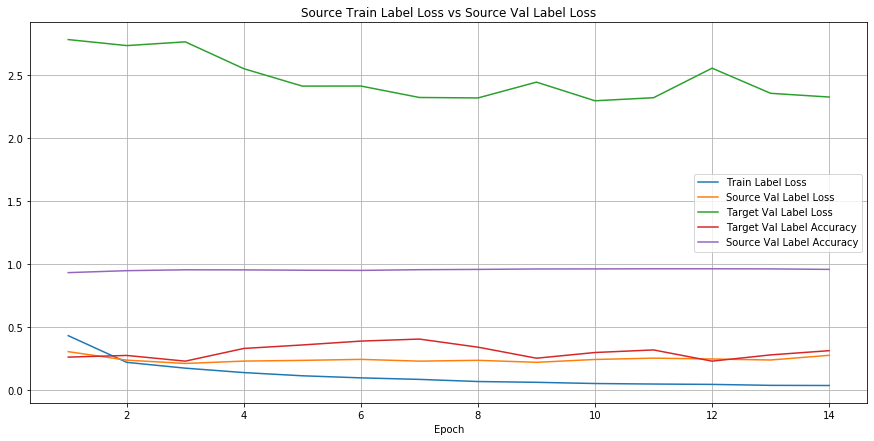

In [25]:
ax = get_loss_curve(experiment)
plt.show()

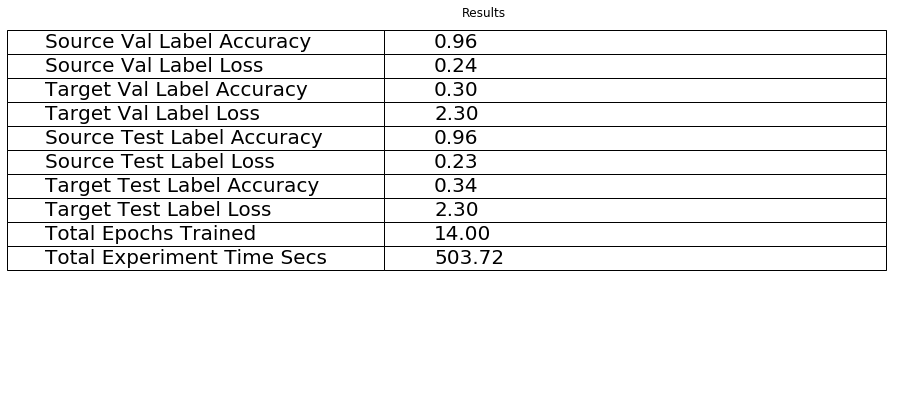

In [26]:
get_results_table(experiment)

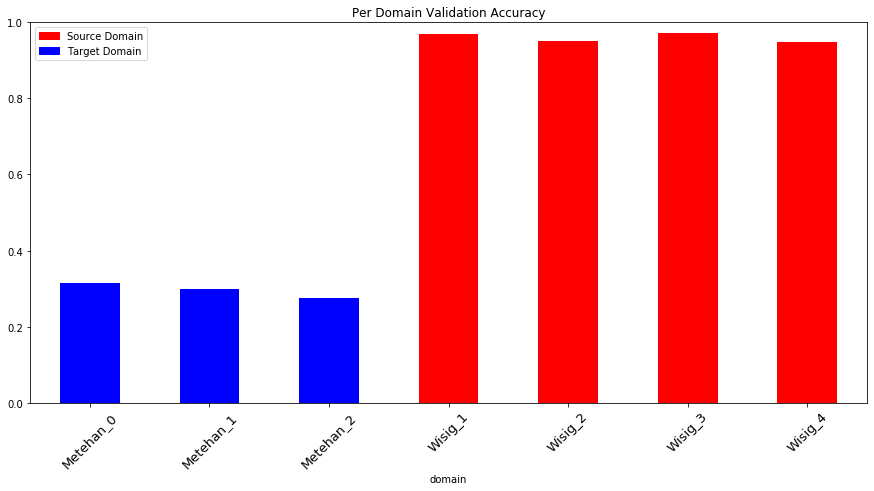

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9598684210526316 Target Test Label Accuracy: 0.33771929824561403
Source Val Label Accuracy: 0.9610197368421053 Target Val Label Accuracy: 0.29678362573099415


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1_wisig-metehan", "parameters": {"experiment_name": "tl_1_wisig-metehan", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 25